# spike train與對應時間的運動狀態

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import itertools
import h5py
from dataPreprocess import read_dataset
from scipy.interpolate import CubicSpline
%matplotlib inline  

sns.set_theme(style='whitegrid', font_scale=2)

In [3]:
mat = h5py.File('/home/jovyan/dataset/indy/Sorted_Spike_Dataset/indy_20160407_02.mat', mode='r') # 讀取要畫的session

spikes = mat['spikes']
timestamp = mat['t'][()].flatten()

df = pd.DataFrame(columns=[])

for ch in range(96):
    tmp = pd.DataFrame(columns=[])
    st = []
    for un in range(3):        
        st.extend(mat[spikes[un, ch]][()].flatten())

    tmp['st'] = st
    tmp['channel'] = ch

    df = df.append(tmp)
df = df[(df['st'] > timestamp[0]) & (df['st'] < timestamp[-1])]
    
finger_pos = mat['finger_pos']  #  (z,-x,-y) to (x,y,z)
finger_pos = np.vstack([-finger_pos[1,:], -finger_pos[2,:], finger_pos[0,:]])
finger_pos = finger_pos[:2, :]

cs_x = CubicSpline(timestamp, finger_pos[0, :])
cs_y = CubicSpline(timestamp, finger_pos[1, :])

finger_vel = np.vstack([cs_x(timestamp, 1), cs_y(timestamp, 1)])
finger_acc = np.vstack([cs_x(timestamp, 2), cs_y(timestamp, 2)])

target_pos = mat['target_pos'][()]

target_pos = target_pos[:, 1:] - target_pos[:, :-1]
target_pos = np.concatenate((target_pos, np.zeros([2, 1])), axis=1)

targetChangeTime = timestamp[(target_pos[0, :] != 0) | (target_pos[1, :] != 0)]

(69.0, 77.0)

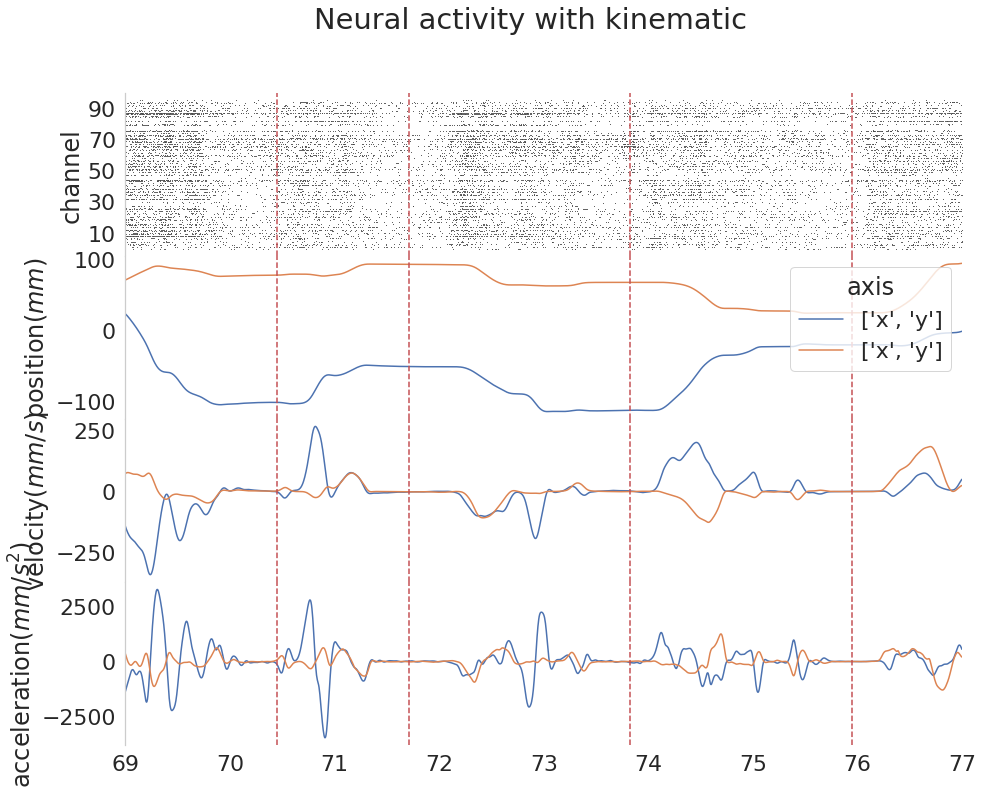

In [4]:
sns.set_theme(style='whitegrid', font_scale=2)

fig, ax = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

df_plot = df[(df['st'] > timestamp[1000]) & (df['st'] < timestamp[3000])]
sns.scatterplot(ax=ax[0], data=df_plot, x='st', y='channel', color='black', s=1)
ax[0].set_yticks(range(10, 96, 20))
# ax[0].set_xticks(timestamp)
# ax[0].set_xticklabels(np.round(timestamp, 4))


ax[1].plot(timestamp[1000:3000], finger_pos[:, 1000:3000].T * 10, label = ['x', 'y'])

ax[2].plot(timestamp[1000:3000], finger_vel[:, 1000:3000].T * 10, label = ['x', 'y'])

ax[3].plot(timestamp[1000:3000], finger_acc[:, 1000:3000].T * 10, label = ['x', 'y'])


vline_x = targetChangeTime[(targetChangeTime > timestamp[1000]) & (targetChangeTime < timestamp[3000])]


for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(True)

    a.grid(False)

    for i in vline_x:
        a.axvline(x=i, c='r', ls='--')

plt.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('Neural activity with kinematic')
ax[0].set_ylabel('channel')
ax[1].set_ylabel('position($mm$)')
ax[2].set_ylabel('velocity($mm/s$)')
ax[3].set_ylabel('acceleration($mm/s^2$)')

ax[1].legend(title='axis', loc='upper right')

plt.xlim([timestamp[1000], timestamp[3000]])